$$\textrm{Joaquin Peñuela Parra}$$
$$\textrm{Universidad de los Andes}$$
$$\textrm{Grupo de Física de Altas Energías: Fenomenología de Partículas}$$

$\textbf{Preliminares}$ 

Las librerías que se usan aquí son las siguientes: 

In [1]:
import os, sys

Path_ML_OUTPUT = os.path.dirname(os.path.realpath('Histos_ML_JP.ipynb.ipynb'))
Path_Leptoquarks_searches = os.path.dirname(Path_ML_OUTPUT)
Path_Pheno_BSM = os.path.dirname(Path_Leptoquarks_searches)

sys.path.append(Path_Pheno_BSM) #Permite importar delphes_reader

import uproot
from ROOT import TFile #Permite guardar y leer los histogramas en un archivo .root

from ROOT import TH1F #Permite graficar los histogramas usando ROOT
from ROOT import TCanvas #Permite poner los histogramas
from ROOT import THStack #Permite graficar varios histogramas al mismo tiempo
from ROOT import TLegend #Permite poner legends cuando se sobrelapan histogramas
from ROOT import TLatex #Permite poner avisos en Latex en las graficas

import pandas as pd

from delphes_reader import Quiet

events_sub_folder = f'{Path_Leptoquarks_searches}/03_delphes_preselection/Selected_Events' #Carpeta donde están los csv preseleccionados

Welcome to JupyROOT 6.26/06


Carguemos los histogramas que creo Cristian:

In [2]:
Masses = ['1000', '1250', '1500', '1750', '2000', '2250']
channels = ['hadronic', 'semileptonic']
processes = ['b_b_tau_tau', 'b_tau_tau']

signals = ['LQ_LQ','Tau_LQ']
bkgs = ['stop','ttbar', 'w_jets', 'ww', 'wz', 'z_jets', 'zz']

In [3]:
with Quiet():

    Histogramas_signal = {}
    Histogramas_bkg = {}

    for M in Masses:
        Histogramas_signal[M] = {}       
        Histogramas_bkg[M] = {}        
        
        for process in processes:
            Histogramas_signal[M][process] = {}
            Histogramas_bkg[M][process] = {}
            
            for channel in channels:
                Histogramas_signal[M][process][channel] = {}
                Histogramas_bkg[M][process][channel] = {}

                ruta = f'{Path_ML_OUTPUT}/MLQ_{M}/{process}_{channel}/Gradient_Boosting.root'

                file = uproot.open(ruta) 
                histogramas = file.keys()
                file.close()

                ROOT_File = TFile.Open(ruta, 'READ')

                for histo in histogramas:   
                    h = ROOT_File.Get(histo)
                    h.SetDirectory(0)
                    h.Rebin(2)

                    if((channel in histo) and (process in histo)): 
                        nombre_histo = histo.replace(channel, '').replace(process, '').replace(M, '').replace('_','').replace(';1','').replace('LQLQ','LQ_LQ').replace('TauLQ', 'Tau_LQ').replace('jets', '_jets')
                        if nombre_histo in signals: Histogramas_signal[M][process][channel][nombre_histo] = h
                        else: Histogramas_bkg[M][process][channel][nombre_histo] = h
                ROOT_File.Close()

Carguemos ttbar para b_tau_tau semileptonic ww debido a que el que generó Cristian tenía un error:

In [4]:
with Quiet():
    for M in Masses:       
        histo_ejemplo = Histogramas_bkg[M]['b_tau_tau']['semileptonic']['ww']

        h = TH1F('sum', 'sum', histo_ejemplo.GetNbinsX(),0.0, 1)

        data = pd.read_csv(f'{Path_Leptoquarks_searches}/04_ML_classification/MLQ_{M}/b_tau_tau_semileptonic/Gradient_Boosting_ttbar.csv')
        valores = data['scores']

        for valor in valores:
            h.Fill(valor)

        h.SetDirectory(0)
        Histogramas_bkg[M]['b_tau_tau']['semileptonic']['ttbar'] = h

Grafiquemos uno para probar:

In [5]:
canvas = TCanvas("Canvas", " ", 600, 400)

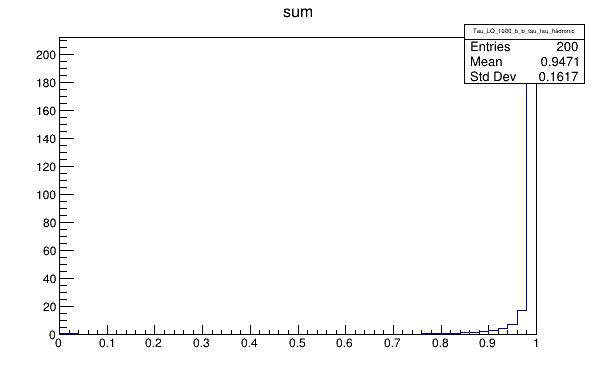

In [6]:
Histogramas_signal['1000']['b_b_tau_tau']['hadronic']['Tau_LQ'].Draw('hist')

canvas.Draw()

Antes de hacer el overlap es necesario definir las funciones que permiten calcular el número de eventos, sumar histogramas y hacer el overlap de los histogramas

In [7]:
def N_events(process, channel, signal):
    
    path_csv = f'{events_sub_folder}/Cutflow_{process}_{channel}.csv'
    cutflow = pd.read_csv(path_csv)
    
    return cutflow[signal][cutflow.shape[0]-1]

def sum_histos(histo_list):
    result = TH1F('sum', 'sum', histo_list[0].GetNbinsX(),0.0,histo_list[0].GetBinWidth(0)*histo_list[0].GetNbinsX())
    result.SetDirectory(0)
    
    for histo in histo_list:
        for i in range(histo.GetNbinsX()):
            #Sumemos los bines
            sum_ = result.GetBinContent(i + 1)
            sum_ = sum_ + histo.GetBinContent(i + 1)
            result.SetBinContent(i+1, sum_)
            #Sumemos el error
            err_ = result.GetBinError(i + 1)
            err_ = err_ + histo.GetBinError(i+1)
            result.SetBinError(i+1, err_)
        
    return result

Definamos la función para hacer el overlap

In [8]:
def Overlap_Histos(histogramas_signal, histogramas_bkg, process, channel,
                   signals, bkgs, Titulo, M, ignorar = '', alpha_bkg = 0.05, alpha_signal = 0.05, 
                   Stack = False, Log_Y = False, Log_X = True,Grid = False):
    
    #Si Stack es False -> Se normaliza por unidad de area
    #Si Stack es True -> Se normaliza según el número de eventos
    
    canvas = TCanvas(Titulo, " ", 800, 600)
    
    #legend = TLegend(0.9,.4,1,.89) #Afuera de la grafica
    legend = TLegend(0.48,.75,0.87,.89)
    legend.SetNColumns(4) 
    legend.SetHeader('M_{U}' + f'= {int(M)/1000} TeV' + ', g_{U} = 1.8' + ', #beta_{R}^{b #tau} = -1',"C")
    legend.SetLineWidth(1)
    
    #legend.SetFillStyle(0) #Así la ventana con los legends es transparente

    Histos = THStack('hist', Titulo)
        
    for i in range(len(bkgs.keys())):
            combinacion_bkg = list(bkgs.keys())[i]
            bkg_list = bkgs[combinacion_bkg]
            
            histo_list = []
            for bkg in bkg_list:
                if (bkg != ignorar):
                    if (histogramas_bkg[M][process][channel][bkg] != {}):
                        h = histogramas_bkg[M][process][channel][bkg]
                        h.Scale(N_events(process, channel, bkg)/h.Integral())
                        histo_list.append(h)
                
            histo_Nevents = sum_histos(histo_list)
            
            histo_normalizado = sum_histos(histo_list)
            histo_normalizado.Scale(1.0/histo_normalizado.Integral())
            
            if (Stack): histo = histo_Nevents
            else: histo = histo_normalizado
            
            color = len(signals.keys()) + i + 1
            if color == 7: color = 3
                
            histo.SetLineColor(color)
            histo.SetFillColorAlpha(color, alpha_bkg)
            histo.SetLineWidth(2)
            histo.SetDirectory(0)     
            
            Histos.Add(histo)
            legend.AddEntry(histo,combinacion_bkg)
            
    for j in range(len(signals.keys())):
            combinacion_signal = list(signals.keys())[j]
            signal_list = signals[combinacion_signal]
            
            histo_list = []
            for signal in signal_list:
                if (signal != ignorar):
                    if (histogramas_signal[M][process][channel][signal] != {}):
                        h = histogramas_signal[M][process][channel][signal]
                        h.Scale(N_events(process, channel, f'{signal}_{M}')/h.Integral())
                        histo_list.append(h)
                
            histo_Nevents = sum_histos(histo_list)
            
            histo_normalizado = sum_histos(histo_list)
            histo_normalizado.Scale(1.0/histo_normalizado.Integral())
            
            if (Stack): histo = histo_Nevents
            else: histo = histo_normalizado
            
            color = j + 1
            if color == 3: color = 7
            
            histo.SetLineColor(color)
            histo.SetFillColorAlpha(color, alpha_signal)
            histo.SetLineStyle(2)
            histo.SetLineWidth(2)
            histo.SetDirectory(0)     
            
            Histos.Add(histo)
            legend.AddEntry(histo,combinacion_signal)
            
    if Log_Y: canvas.SetLogy()
    if Log_X: canvas.SetLogx()
    if Grid: canvas.SetGrid()
    
    eje_x = 'XGB-Output'
    
    if Stack:
        Histos.Draw("hist")
        Histos.SetTitle(f'{Titulo}; {eje_x}; Events')  
        
    else: 
        Histos.Draw("histnostack")
        Histos.SetTitle(f'{Titulo}; {eje_x}; A.U')  
    
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.DrawLatex(0.76,0.91,'#sqrt{s} = 13 TeV')
    #latex.DrawLatex(0.61,0.91,'#sqrt{s} = 13 TeV, L = 137 fb^{-1}')

    
    canvas.Draw()
    legend.Draw('same')
    
    #Histos.GetXaxis().SetLimits(0.0, float(M)*3)  
    
    return Histos, canvas, legend

Probemos para M = 1500

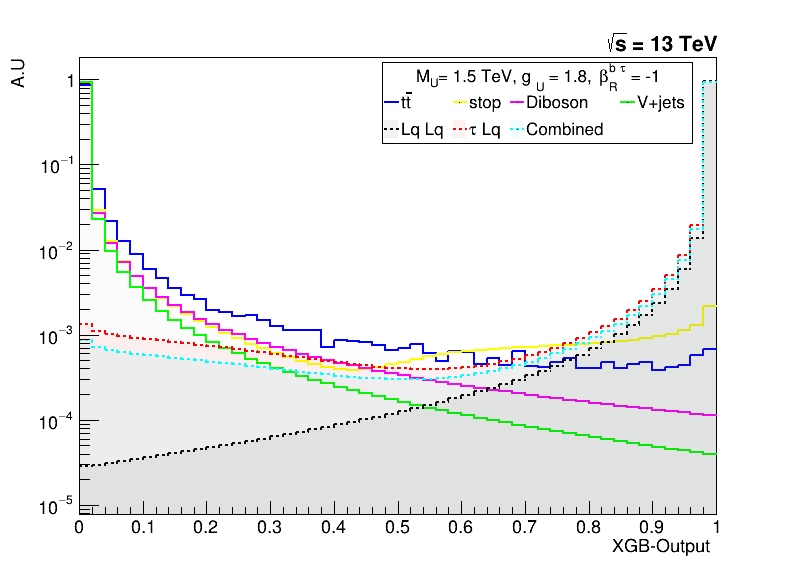

In [9]:
Histos, canvas, legend= Overlap_Histos(histogramas_signal = Histogramas_signal, 
                                       histogramas_bkg = Histogramas_bkg, 
                                       process = 'b_tau_tau', 
                                       channel = 'semileptonic',
                                       signals = {'Lq Lq': ['LQ_LQ'], '#tau Lq': ['Tau_LQ'], 'Combined':  ['LQ_LQ', 'Tau_LQ']}, 
                                       bkgs = {'t#bar{t}': ['ttbar'], 'stop': ['stop'], 'Diboson': ['ww', 'wz', 'zz'], 'V+jets': ['w_jets', 'z_jets']}, 
                                       Titulo = '', 
                                       M = '1500', 
                                       ignorar = '', 
                                       alpha_bkg = 0, alpha_signal = 0.05, 
                                       Stack = False, Log_Y = True, Log_X = False,Grid = False)

Ahora generemos todos los .pdf

In [10]:
!rm -rf Histos_Overlap
!mkdir -p Histos_Overlap

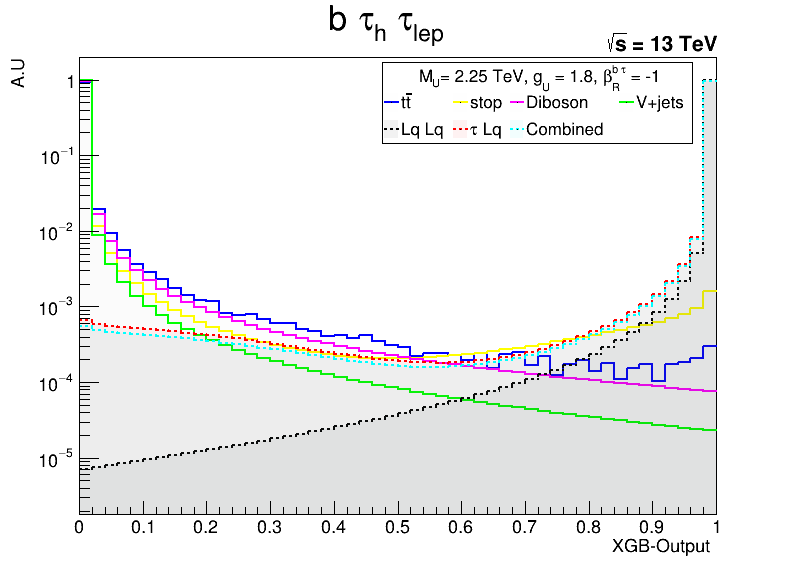

In [11]:
with Quiet():

    for Masa in Masses:
        !mkdir -p Histos_Overlap/MLQ_{Masa}
        for proceso in processes:
            for canal in channels:
                
                if (proceso == 'b_tau_tau' and canal == 'hadronic'): titulo = 'b #tau_{h} #tau_{h}'
                if (proceso == 'b_b_tau_tau' and canal == 'hadronic'): titulo = 'b b #tau_{h} #tau_{h}'
                if (proceso == 'b_tau_tau' and canal == 'semileptonic'): titulo = 'b #tau_{h} #tau_{lep}  '
                if (proceso == 'b_b_tau_tau' and canal == 'semileptonic'): titulo = 'b b #tau_{h} #tau_{lep}  '                
                
                path = f'/MLQ_{Masa}/ML_{proceso}_{canal}_wRHC'

                Histos, canvas, legend= Overlap_Histos(histogramas_signal = Histogramas_signal, 
                                                       histogramas_bkg = Histogramas_bkg, 
                                                       process = proceso, 
                                                       channel = canal,
                                                       signals = {'Lq Lq': ['LQ_LQ'], '#tau Lq': ['Tau_LQ'], 'Combined':  ['LQ_LQ', 'Tau_LQ']}, 
                                                       bkgs = {'t#bar{t}': ['ttbar'], 'stop': ['stop'], 'Diboson': ['ww', 'wz', 'zz'], 'V+jets': ['w_jets', 'z_jets']}, 
                                                       Titulo = titulo, 
                                                       M = Masa, 
                                                       ignorar = '', 
                                                       alpha_bkg = 0, alpha_signal = 0.05, 
                                                       Stack = False, Log_Y = True, Log_X = False,Grid = False)

                canvas.Print(f'Histos_Overlap/{path}.pdf')

Faltaría hacer esto mismo para el caso woRCH